<a href="https://colab.research.google.com/github/antonellagambarte/procesamiento_del_lenguaje_I/blob/main/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag )
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# seleccionamos el tamaño de contexto
max_context_size = 100


# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)


# la longitud de vocabulario de caracteres es:
len(chars_vocab)


# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

Tokenizar

In [5]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

tokenized_text[:1000]

[74,
 70,
 21,
 74,
 30,
 43,
 0,
 56,
 63,
 20,
 43,
 74,
 27,
 65,
 74,
 30,
 70,
 74,
 0,
 29,
 69,
 43,
 74,
 30,
 70,
 74,
 5,
 60,
 47,
 75,
 41,
 74,
 0,
 56,
 74,
 42,
 3,
 43,
 41,
 74,
 70,
 21,
 74,
 15,
 46,
 43,
 55,
 70,
 1,
 43,
 46,
 74,
 21,
 56,
 30,
 70,
 63,
 24,
 46,
 43,
 14,
 33,
 41,
 74,
 70,
 63,
 42,
 46,
 2,
 74,
 36,
 8,
 46,
 26,
 15,
 56,
 30,
 29,
 0,
 70,
 63,
 42,
 70,
 74,
 29,
 74,
 1,
 59,
 74,
 4,
 43,
 20,
 29,
 46,
 41,
 74,
 1,
 56,
 42,
 59,
 29,
 30,
 43,
 74,
 70,
 63,
 74,
 70,
 21,
 74,
 63,
 67,
 0,
 70,
 46,
 43,
 74,
 5,
 38,
 74,
 30,
 70,
 74,
 21,
 29,
 74,
 33,
 52,
 63,
 56,
 20,
 50,
 1,
 42,
 46,
 29,
 1,
 1,
 70,
 41,
 74,
 59,
 63,
 29,
 36,
 8,
 74,
 30,
 70,
 74,
 21,
 29,
 1,
 74,
 14,
 29,
 21,
 21,
 70,
 1,
 74,
 0,
 26,
 1,
 74,
 42,
 46,
 29,
 30,
 56,
 14,
 56,
 43,
 63,
 29,
 21,
 70,
 1,
 74,
 30,
 70,
 21,
 74,
 24,
 29,
 46,
 46,
 56,
 43,
 74,
 29,
 63,
 42,
 56,
 20,
 59,
 43,
 74,
 30,
 70,
 74,
 4,
 29,
 0,
 24,


Organizando y estructurando el dataset

In [6]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))


# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]


tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]


tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]


X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [7]:
X.shape

X[0,:10]
y[0,:10]
vocab_size = len(chars_vocab)

Definiendo el modelo

In [8]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 78)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        55,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 78)       │        15,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,478 (279.21 KB)

 Trainable params: 71,478 (279.21 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

Epoch 1/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4520
 mean perplexity: 6.474738266517834 

Saved new model!
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - loss: 2.4518
Epoch 2/20
1519/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9556
 mean perplexity: 5.595232849607888 

Saved new model!
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - loss: 1.9555
Epoch 3/20
1520/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8516
 mean perplexity: 5.256084032788907 

Saved new model!
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - loss: 1.8516
Epoch 4/20
1521/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8048
 mean perplexity: 5.063877788331282 

Saved new model!
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - loss: 1.8048
Epoch 5/20
1521/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7777
 mean perplexity: 4.971494968418732 

Saved new model!
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 1.7777
Epoch 6/20
1520/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7605
 mean

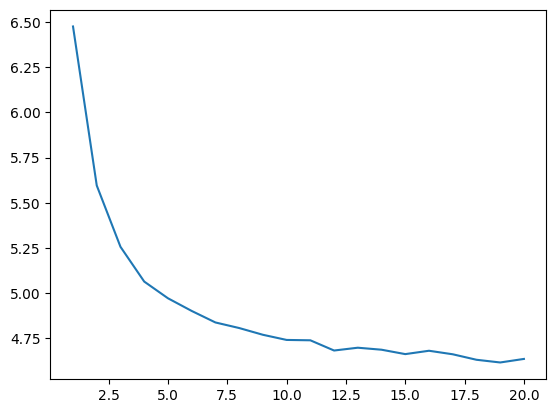

In [10]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)


import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()


# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')